In [1]:
import numpy as np
import nyu
import scipy as sp
import scipy.io
import skimage
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('image', cmap='gray') # set default image colormap to gray

# try gaussian weighting of neighboring patches?

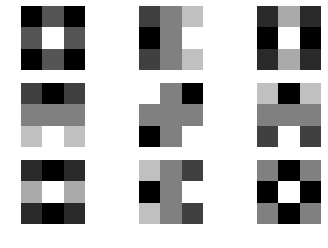

In [2]:
# 3x3 Laws filters from [Saxena et al. 2007]
L3 = np.array([1, 2, 1]) / 128 / .2
E3 = [-1, 0, 1]
S3 = [-1, 2, -1]

L3L3 = np.outer(L3, L3)
L3E3 = np.outer(L3, E3)
L3S3 = np.outer(L3, S3)
E3L3 = np.outer(E3, L3)
E3E3 = np.outer(E3, E3)
E3S3 = np.outer(E3, S3)
S3L3 = np.outer(S3, L3)
S3E3 = np.outer(S3, E3)
S3S3 = np.outer(S3, S3)

f, ax = plt.subplots(3, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(L3L3)
ax[0, 1].imshow(L3E3)
ax[0, 2].imshow(L3S3)
ax[1, 0].imshow(E3L3)
ax[1, 1].imshow(E3E3)
ax[1, 2].imshow(E3S3)
ax[2, 0].imshow(S3L3)
ax[2, 1].imshow(S3E3)
ax[2, 2].imshow(S3S3)

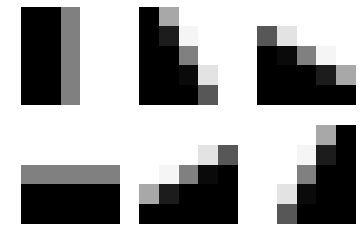

In [4]:
# Oriented edge filters from [Nevatia 1980]
NB0 = np.tile([-100, -100, 0, 100, 100], (5, 1)) / 2000
NB30 = np.array([
    [-100, 32, 100, 100, 100],
    [-100, -78, 92, 100, 100],
    [-100, -100, 0, 100, 100],
    [-100, -100, -92, 78, 100],
    [-100, -100, -100, -32, 100],
]) / 2000

NB60 = -NB30.T
NB90 = -NB0.T
NB120 = -np.flipud(NB60)
NB150 = NB120.T

f, ax = plt.subplots(2, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(NB0)
ax[0, 1].imshow(NB30)
ax[0, 2].imshow(NB60)
ax[1, 0].imshow(NB90)
ax[1, 1].imshow(NB120)
ax[1, 2].imshow(NB150)

In [6]:
def rescale(X):
    max_ = np.max(X)
    min_ = np.min(X)
    
    return (X - min_) / (max_ - min_)

def rescale_abs(X):
    return np.abs(rescale(X) - .5) # FIXME

Found nyu_depth_v2_labeled.mat
Found splits.mat


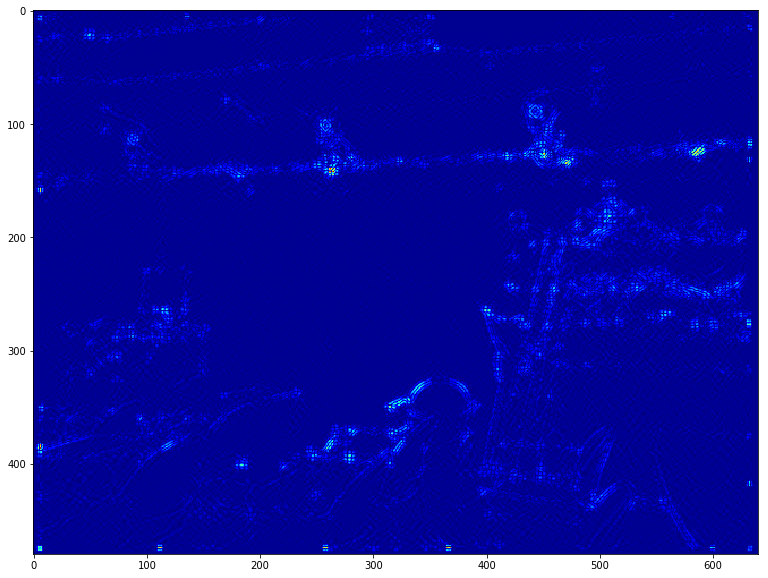

In [13]:
#asdf = sp.ndimage.filters.convolve(nyu['images'][train_indices[0]], L3L3)
#plt.imshow(asdf, cmap='gray')
data, splits = nyu.get_data()
train_indices = splits['trainNdxs'].flatten()
example = np.transpose(data['images'][train_indices[2]], (2, 1, 0))
ycbcr = skimage.color.rgb2ycbcr(example)

blurred = sp.ndimage.filters.gaussian_filter(ycbcr[:, :, 0], 1)
filtered = sp.ndimage.filters.convolve(blurred, S3S3) / 255.0
plt.figure(figsize=(20,10))
plt.imshow(rescale_abs(filtered), cmap='jet')


In [3]:
# Adapted from [Ma, Geng, Bie 2017] pure CNN network

import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape
from tensorflow.keras.models import Sequential
import loss

N_EPOCHS = 40
BATCH_SIZE = 1

sequence = nyu.NyuSequence(batch_size=1, dims=(320, 240), depth_scale=.25)

H, W, _ = sequence.data_shape()
N = np.float32(W * H)
def scale_invariant_loss(y_true, y_pred):
    #D = K.log(y_pred)
    #D_star = K.log(y_true)
    # THESE CAUSE NaNs!
    
    D = y_pred
    D_star = y_true
    d = D - D_star
    
    loss = (1 / N) * K.sum(K.pow(d, 2)) - (1 / K.pow(N, 2)) * K.pow(K.sum(d), 2)
    return loss

model = Sequential([
    Conv2D(96, 11, strides=4, activation='relu', padding='valid', input_shape=sequence.data_shape()),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(256, 5, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(384, 3, activation='relu', padding='same'),
    Conv2D(384, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4800, activation='linear'),
    Reshape((60, 80, 1))
])

for layer in model.layers:
    print(layer.output_shape)

model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam())
model.summary()
model.fit_generator(sequence, epochs=5, verbose=1)

Found nyu_depth_v2_labeled.mat
Found splits.mat
(None, 58, 78, 96)
(None, 28, 38, 96)
(None, 28, 38, 96)
(None, 28, 38, 256)
(None, 13, 18, 256)
(None, 13, 18, 256)
(None, 13, 18, 384)
(None, 13, 18, 384)
(None, 13, 18, 256)
(None, 6, 8, 256)
(None, 12288)
(None, 4096)
(None, 4800)
(None, 60, 80, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 78, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 38, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 38, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 38, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13,

c:\users\cobrien\.virtualenvs\side-nxa1q_zc\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\cobrien\.virtualenvs\side-nxa1q_zc\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


314/795 [==========>...................] - ETA: 2:07:07 - loss: 0.40 - ETA: 1:04:41 - loss: 0.44 - ETA: 43:53 - loss: 0.4444 - ETA: 33:29 - loss: 0.36 - ETA: 27:14 - loss: 0.30 - ETA: 23:04 - loss: 0.26 - ETA: 20:05 - loss: 0.24 - ETA: 17:51 - loss: 0.34 - ETA: 16:08 - loss: 0.31 - ETA: 14:45 - loss: 0.29 - ETA: 13:35 - loss: 0.28 - ETA: 12:38 - loss: 0.29 - ETA: 11:49 - loss: 0.29 - ETA: 11:08 - loss: 0.34 - ETA: 10:33 - loss: 0.32 - ETA: 10:02 - loss: 0.31 - ETA: 9:33 - loss: 0.3216 - ETA: 9:09 - loss: 0.330 - ETA: 8:47 - loss: 0.315 - ETA: 8:27 - loss: 0.324 - ETA: 8:09 - loss: 0.314 - ETA: 7:53 - loss: 0.302 - ETA: 7:38 - loss: 0.293 - ETA: 7:24 - loss: 0.282 - ETA: 7:11 - loss: 0.275 - ETA: 7:00 - loss: 0.268 - ETA: 6:48 - loss: 0.271 - ETA: 6:38 - loss: 0.264 - ETA: 6:29 - loss: 0.265 - ETA: 6:20 - loss: 0.296 - ETA: 6:12 - loss: 0.304 - ETA: 6:04 - loss: 0.296 - ETA: 5:57 - loss: 0.294 - ETA: 5:50 - loss: 0.292 - ETA: 5:43 - loss: 0.289 - ETA: 5:37 - loss: 0.293 - ETA: 5:31 - lo

639/795 [=======================>......] - ETA: 1:42 - loss: 0.260 - ETA: 1:42 - loss: 0.260 - ETA: 1:41 - loss: 0.260 - ETA: 1:41 - loss: 0.259 - ETA: 1:41 - loss: 0.259 - ETA: 1:41 - loss: 0.258 - ETA: 1:40 - loss: 0.258 - ETA: 1:40 - loss: 0.258 - ETA: 1:40 - loss: 0.258 - ETA: 1:39 - loss: 0.258 - ETA: 1:39 - loss: 0.257 - ETA: 1:39 - loss: 0.257 - ETA: 1:39 - loss: 0.256 - ETA: 1:38 - loss: 0.256 - ETA: 1:38 - loss: 0.255 - ETA: 1:38 - loss: 0.255 - ETA: 1:38 - loss: 0.255 - ETA: 1:37 - loss: 0.255 - ETA: 1:37 - loss: 0.255 - ETA: 1:37 - loss: 0.254 - ETA: 1:37 - loss: 0.254 - ETA: 1:36 - loss: 0.254 - ETA: 1:36 - loss: 0.253 - ETA: 1:36 - loss: 0.253 - ETA: 1:36 - loss: 0.253 - ETA: 1:35 - loss: 0.252 - ETA: 1:35 - loss: 0.252 - ETA: 1:35 - loss: 0.251 - ETA: 1:35 - loss: 0.251 - ETA: 1:34 - loss: 0.250 - ETA: 1:34 - loss: 0.250 - ETA: 1:34 - loss: 0.249 - ETA: 1:34 - loss: 0.249 - ETA: 1:33 - loss: 0.248 - ETA: 1:33 - loss: 0.248 - ETA: 1:33 - loss: 0.248 - ETA: 1:33 - loss: 0.2

795/795 [==============================] - ETA: 31s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24

314/795 [==========>...................] - ETA: 2:14 - loss: 0.073 - ETA: 2:26 - loss: 0.073 - ETA: 2:30 - loss: 0.083 - ETA: 2:32 - loss: 0.117 - ETA: 2:31 - loss: 0.169 - ETA: 2:29 - loss: 0.147 - ETA: 2:26 - loss: 0.149 - ETA: 2:26 - loss: 0.165 - ETA: 2:24 - loss: 0.157 - ETA: 2:24 - loss: 0.151 - ETA: 2:25 - loss: 0.144 - ETA: 2:23 - loss: 0.148 - ETA: 2:23 - loss: 0.153 - ETA: 2:23 - loss: 0.145 - ETA: 2:23 - loss: 0.137 - ETA: 2:23 - loss: 0.162 - ETA: 2:22 - loss: 0.169 - ETA: 2:22 - loss: 0.163 - ETA: 2:22 - loss: 0.163 - ETA: 2:21 - loss: 0.160 - ETA: 2:21 - loss: 0.160 - ETA: 2:21 - loss: 0.163 - ETA: 2:21 - loss: 0.158 - ETA: 2:21 - loss: 0.155 - ETA: 2:21 - loss: 0.163 - ETA: 2:20 - loss: 0.160 - ETA: 2:20 - loss: 0.161 - ETA: 2:20 - loss: 0.161 - ETA: 2:20 - loss: 0.165 - ETA: 2:20 - loss: 0.167 - ETA: 2:20 - loss: 0.163 - ETA: 2:19 - loss: 0.166 - ETA: 2:19 - loss: 0.164 - ETA: 2:19 - loss: 0.164 - ETA: 2:19 - loss: 0.164 - ETA: 2:19 - loss: 0.168 - ETA: 2:19 - loss: 0.1

795/795 [==============================] - ETA: 28s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 26s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 21s - loss: 0.24 - ETA: 21s - loss: 0.24 - ETA: 21s - loss: 0.24 - ETA: 21s - loss: 0.24 - ETA: 21s - loss: 0.23 - ETA: 20s - loss: 0.24

314/795 [==========>...................] - ETA: 2:26 - loss: 0.287 - ETA: 2:20 - loss: 0.182 - ETA: 2:20 - loss: 0.134 - ETA: 2:21 - loss: 0.122 - ETA: 2:22 - loss: 0.120 - ETA: 2:20 - loss: 0.162 - ETA: 2:23 - loss: 0.157 - ETA: 2:22 - loss: 0.148 - ETA: 2:22 - loss: 0.143 - ETA: 2:21 - loss: 0.361 - ETA: 2:21 - loss: 0.366 - ETA: 2:21 - loss: 0.344 - ETA: 2:21 - loss: 0.368 - ETA: 2:22 - loss: 0.386 - ETA: 2:22 - loss: 0.365 - ETA: 2:22 - loss: 0.393 - ETA: 2:21 - loss: 0.396 - ETA: 2:21 - loss: 0.384 - ETA: 2:22 - loss: 0.370 - ETA: 2:21 - loss: 0.357 - ETA: 2:20 - loss: 0.343 - ETA: 2:20 - loss: 0.335 - ETA: 2:20 - loss: 0.330 - ETA: 2:20 - loss: 0.350 - ETA: 2:20 - loss: 0.343 - ETA: 2:20 - loss: 0.340 - ETA: 2:20 - loss: 0.334 - ETA: 2:20 - loss: 0.325 - ETA: 2:19 - loss: 0.319 - ETA: 2:19 - loss: 0.310 - ETA: 2:19 - loss: 0.309 - ETA: 2:19 - loss: 0.303 - ETA: 2:19 - loss: 0.324 - ETA: 2:19 - loss: 0.318 - ETA: 2:18 - loss: 0.310 - ETA: 2:18 - loss: 0.304 - ETA: 2:18 - loss: 0.3

795/795 [==============================] - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 21s - loss: 0.23

314/795 [==========>...................] - ETA: 2:26 - loss: 0.154 - ETA: 2:26 - loss: 0.292 - ETA: 2:24 - loss: 0.244 - ETA: 2:28 - loss: 0.193 - ETA: 2:25 - loss: 0.177 - ETA: 2:27 - loss: 0.165 - ETA: 2:24 - loss: 0.200 - ETA: 2:24 - loss: 0.202 - ETA: 2:24 - loss: 0.202 - ETA: 2:24 - loss: 0.329 - ETA: 2:24 - loss: 0.303 - ETA: 2:23 - loss: 0.289 - ETA: 2:23 - loss: 0.269 - ETA: 2:23 - loss: 0.258 - ETA: 2:23 - loss: 0.252 - ETA: 2:23 - loss: 0.241 - ETA: 2:22 - loss: 0.238 - ETA: 2:22 - loss: 0.230 - ETA: 2:22 - loss: 0.227 - ETA: 2:22 - loss: 0.222 - ETA: 2:22 - loss: 0.228 - ETA: 2:22 - loss: 0.225 - ETA: 2:21 - loss: 0.222 - ETA: 2:21 - loss: 0.219 - ETA: 2:21 - loss: 0.216 - ETA: 2:21 - loss: 0.216 - ETA: 2:21 - loss: 0.213 - ETA: 2:20 - loss: 0.225 - ETA: 2:20 - loss: 0.224 - ETA: 2:20 - loss: 0.218 - ETA: 2:20 - loss: 0.233 - ETA: 2:20 - loss: 0.231 - ETA: 2:19 - loss: 0.227 - ETA: 2:19 - loss: 0.225 - ETA: 2:19 - loss: 0.230 - ETA: 2:19 - loss: 0.244 - ETA: 2:19 - loss: 0.2

795/795 [==============================] - ETA: 28s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 25s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 24s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 20s - loss: 0.23

314/795 [==========>...................] - ETA: 2:39 - loss: 0.682 - ETA: 2:32 - loss: 0.445 - ETA: 2:34 - loss: 0.361 - ETA: 2:31 - loss: 0.355 - ETA: 2:29 - loss: 0.307 - ETA: 2:29 - loss: 0.285 - ETA: 2:26 - loss: 0.260 - ETA: 2:27 - loss: 0.231 - ETA: 2:30 - loss: 0.236 - ETA: 2:29 - loss: 0.222 - ETA: 2:30 - loss: 0.235 - ETA: 2:30 - loss: 0.244 - ETA: 2:29 - loss: 0.280 - ETA: 2:28 - loss: 0.326 - ETA: 2:28 - loss: 0.312 - ETA: 2:28 - loss: 0.307 - ETA: 2:28 - loss: 0.335 - ETA: 2:29 - loss: 0.322 - ETA: 2:29 - loss: 0.309 - ETA: 2:28 - loss: 0.296 - ETA: 2:30 - loss: 0.290 - ETA: 2:30 - loss: 0.286 - ETA: 2:29 - loss: 0.283 - ETA: 2:28 - loss: 0.284 - ETA: 2:28 - loss: 0.274 - ETA: 2:28 - loss: 0.295 - ETA: 2:28 - loss: 0.286 - ETA: 2:27 - loss: 0.277 - ETA: 2:27 - loss: 0.278 - ETA: 2:27 - loss: 0.271 - ETA: 2:27 - loss: 0.267 - ETA: 2:26 - loss: 0.264 - ETA: 2:26 - loss: 0.259 - ETA: 2:26 - loss: 0.257 - ETA: 2:26 - loss: 0.252 - ETA: 2:26 - loss: 0.249 - ETA: 2:26 - loss: 0.2

795/795 [==============================] - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 24s - loss: 0.22 - ETA: 24s - loss: 0.22 - ETA: 24s - loss: 0.22 - ETA: 24s - loss: 0.22 - ETA: 24s - loss: 0.22 - ETA: 23s - loss: 0.22 - ETA: 23s - loss: 0.22 - ETA: 23s - loss: 0.22 - ETA: 23s - loss: 0.22 - ETA: 23s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22

In [4]:
model.layers[0].get_weights()

[array([[[[ 2.08952604e-03,  3.69816367e-03,  2.17176210e-02, ...,
            2.73797498e-03,  1.87032856e-02, -1.22589609e-02],
          [-9.53799393e-03,  1.43068852e-02, -2.00139196e-03, ...,
           -8.58571194e-03,  7.91997369e-03, -1.94232520e-02],
          [ 1.91969483e-03,  5.05947694e-03,  2.06579957e-02, ...,
            4.21920046e-03,  1.91500373e-02,  8.07217415e-03]],
 
         [[-1.39995571e-02,  2.90027596e-02, -1.52592771e-02, ...,
           -2.72662123e-03,  2.66154315e-02, -4.85350704e-03],
          [-4.71311854e-03,  1.18464306e-02, -1.68586744e-03, ...,
           -1.58847384e-02, -5.77801745e-03, -1.58692133e-02],
          [ 1.71895660e-02,  8.51798058e-03, -1.15009993e-02, ...,
            2.00976431e-02,  1.95818208e-02, -3.50721925e-03]],
 
         [[-6.57188892e-03, -9.96661652e-03, -1.28305834e-02, ...,
           -1.31140081e-02,  1.20975142e-02, -1.00743072e-02],
          [ 1.80133898e-02, -4.57516173e-03,  1.87656842e-02, ...,
           -1.941

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


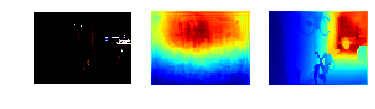

In [5]:
X, y = sequence[53]
img = X[0]
depth = y[0]
pred = model.predict(X)[0]

f, ax = plt.subplots(1, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0].imshow(img)
ax[1].imshow(pred[:, :, 0], cmap='jet')
ax[2].imshow(depth[:, :, 0], cmap='jet')

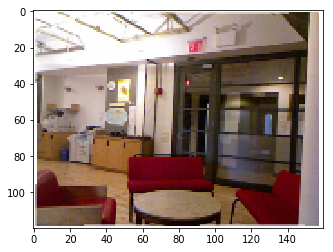

In [67]:
plt.imshow(skimage.transform.resize(example, (120, 160)))

Found nyu_depth_v2_labeled.mat
Found splits.mat


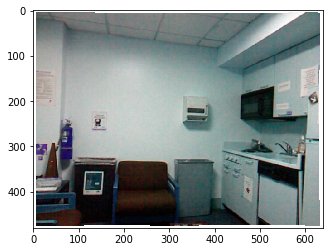

In [14]:
import nyu

data, split = nyu.get_data()
r, g, b = data['images'][0][:,]

plt.imshow(np.transpose(np.array([b, g, r]), (2, 1, 0)))